#Vorverarbeitung des Loan-Logs

Quellen und Packages: 
- Dataset: https://www.win.tue.nl/bpi/doku.php?id=2017:challenge

Loan-Log wird in Datensatz mit ganzen Instanz-Graphen transformiert

In [ ]:
#torch.__version__

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [ ]:
%%capture
!pip install pm4py

In [ ]:
%load_ext autoreload
%autoreload 2

## Get Data & Dataunderstanding

Data understanding: BPIC 2017: Business process mining – A Loan
process application

In [ ]:
import torch
import pm4py
import numpy as np
from pathlib import Path

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The event log provided this year contains all applications filed in 2016, and their subsequent handling up to February 2nd 2017. In total, there are 1,202,267 events pertaining to 31,509 loan applications. For these applications, a total of 42,995 offers were created. As in 2012, we have three types of events, namely Application state changes, Offer state changes and Workflow events. There are 149 originators in the data, i.e. employees or systems of the company.

For all applications, the following data is available:

- Requested load amount (in Euro),
- The application type,
- The reason the loan was applied for (LoanGoal), and
- An application ID.


For all offers, the following data is available:

- An offer ID,
- The offered amount,
- The initial withdrawal amount,
- The number of payback terms agreed to,
- The monthly costs,
- The creditscore of the customer,
- The employee who created the offer,
- Whether the offer was selected, and
- Whether the offer was accepted by the customer.

## Create Dataset

In [ ]:
# Hauptordner-Pfad
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
# Speicherort des Moduls
%cd /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from tqdm import tqdm
import joblib

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
#%from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from torch_geometric.utils import to_networkx
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
import pm4py
import networkx as nx
import matplotlib.pyplot as plt

class LoanApplicationDataset(InMemoryDataset):
    def __init__(self, root, df, feature, transform=None, pre_transform=None):
        self.df = df
        self.feature = feature
        super(LoanApplicationDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['./loan.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []

        # process by session_id
        grouped = self.df.groupby('ProcessID')

        # Define group to be explained in the TestSet
        # X_test = df_log_a[df_log_a["ProcessID"]==8]
        
        for ProcessID, group in grouped:           
            # Sortieren nach Timestamp, sodass sich die Events in richtiger zeitlicher Reihenfolge befinden
            # group = group.sort_values("Timestamp")
                      
            # Eindeutige Ids für Events vergeben. Dient der Vorbereitung auf das Bestimmen von Knoten
            ids =  pd.factorize(group[self.feature].apply(tuple, axis=1))[0] 
            group["NodeId"] = ids
            #self.node_ids.append(ids)                     
            
            # Knoten aus den One-Hot-Encodeden Featuren bestimmen. node_feature speichert alle möglichen Knoten 
            node_features = group.loc[group.ProcessID==ProcessID,["NodeId"]+ self.feature].sort_values('NodeId').drop_duplicates(subset=["NodeId"]).drop(columns = ["NodeId"]).values
            # node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').drop_duplicates(subset = ["sess_item_id"]).values 
            
            #node_features zu Tensor transformieren
            node_features = torch.from_numpy(node_features).float().to(device) #.unsqueeze(1)

            # Ziel- und Quellknoten bestimmen. 
            # Eine direktionale Kante wird zwischen zwei aufeinander folgenden Knoten von i nach j platziert, wen gilt: i <= j 
            target_nodes = group.NodeId.values[1:]
            source_nodes = group.NodeId.values[:-1]
            x = node_features            
            
            # 2 Dim Tensor zur Kantenbestimmung erstellen
            edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)            
            
            # Label der Prozess-Instanz 
            y = torch.cuda.FloatTensor([group.Label.values[0]])            

            # Graph-Instanz als Data-Objekt 
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        
class LoanApplication():
    def __init__(self, feature, label_encoder, normalization, remove_self_loops):
      # End Events:
      self.process_end = ["A_Pending", "A_Denied", "A_Cancelled"]
      # Feature:
      self.feature = feature
      self.label_encoder = label_encoder
      self.normalization = normalization
      self.remove_self_loops = remove_self_loops

    def load_dataset(self, path, log = False):
      # Read Dataset
      # log_o = pm4py.read_xes(path + 'BPI_Challenge_2017_Offer.xes')
      log_a = pm4py.read_xes(str(path / "BPI_Challenge_2017.xes"))

      # Transform to Dataframe
      # pd_o = pm4py.convert_to_dataframe(log_o)
      pd_a = pm4py.convert_to_dataframe(log_a)

      if log == True:
        return log_a, pd_a

      return pd_a

    def preprocess_dataset(self, df):
      # Rename Columns
      df.rename(columns={"concept:name":"Events", "case:concept:name":"ProcessID", "time:timestamp": "Timestamp", "case:LoanGoal": "LoanGoal", "lifecycle:transition": "Transition"}, inplace=True)

      # Select columns for Modell training
      df = df[self.feature + ["ProcessID", "Timestamp"]]

      # End Events: Sagen aus, ob Credit gewährt wurde oder nicht. Werden aus Process Entfernt und als Label verwedent
      # Siehe Analyse der End Events weiter unten: Löschen der Gruppe mit zwei A_Denied Events 
      # Anzahl der Reihen von Events in einer Gruppe
      g3 = df.groupby(['ProcessID', 'Events']).agg(number_of_rows=('Events', 'count')).reset_index()


      # Prozesse mit mehreren End-Events löschen, falls enthalten
      try:
        # ProcessID der Gruppe erhalten (TODO: Warum process_end[1])
        a = g3[(g3["number_of_rows"] >= 2) & (g3["Events"].isin(self.process_end[1]))]["ProcessID"].values[0]
        # Aus Dataframe löschen
        df = df[df["ProcessID"] != a]
      except: 
        pass 
      
     
      

      # Convertieren von Timestamps zu Integer Timestamps
      df["Timestamp"] = df["Timestamp"].apply(lambda x: int(x.timestamp()))

      # Spalte mit Label der Bewerbungsprozesse (Gruppen) erstellen + Start- und Endknoten hinzzufügen
      df = df.groupby("ProcessID").apply(lambda x: self.add_label_and_nodes(x))
      df.reset_index(drop = True, inplace = True) 

      # Datensatz auf W-Events beschränken
      df = df[df["Events"].str.startswith(('W_', "st", "end")) ]

      if self.remove_self_loops == True:
        # Datensatz self-loops entfernen
        first_row = df.iloc[0].values    # Erste Reihe speichern, da diese sonst mitentfernt wird
        df["vergleich"] = df[['Events', "Action"]].ne(df[['Events',"Action"]].shift().bfill()).astype(int).sum(axis=1)     
        df = df[(df["vergleich"] != 0)]   # Entfernen gleicher aufeinander folgender Reihen 
        df = df.drop(labels = "vergleich", axis=1)
        df.loc[-1] = first_row
        df.index = df.index + 1  # Index anpassen
        df.sort_index(inplace=True) 

      
      
      # Rebalance Dataset: Die Anzahl von Prozess-Instanzen verschiedener Klassen wird durch entfernen von Instanzen angepasst
      # df = self.rebalance_dataset(df)
      
      

      # create Pytorch Dataset 
      # dataset = L# oanApplicationDataset(root="../")

      return df

    def preprocess_dataset_analysis(self, df):
      # Rename Columns
      # df.rename(columns={"concept:name":"Events", "case:concept:name":"ProcessID", "time:timestamp": "Timestamp", "case:LoanGoal": "LoanGoal" }, inplace=True)

      # Select columns for Modell training
      # df = df[self.feature + ["ProcessID", "Timestamp"]]

      # End Events: Sagen aus, ob Credit gewährt wurde oder nicht. Werden aus Process Entfernt und als Label verwedent
      # Siehe Analyse der End Events weiter unten: Löschen der Gruppe mit zwei A_Denied Events 
      # Anzahl der Reihen von Events in einer Gruppe
      g3 = df.groupby(['case:concept:name', 'concept:name']).agg(number_of_rows=('concept:name', 'count')).reset_index()

      # Prozesse mit mehreren End-Events löschen, falls enthalten
      try:
        # ProcessID der Gruppe erhalten (TODO: Warum process_end[1])
        a = g3[(g3["number_of_rows"] >= 2) & (g3["concept:name"].isin(self.process_end[1]))]["case:concept:name"].values[0]
        # Aus Dataframe löschen
        df = df[df["case:concept:name"] != a]
      except: 
        pass 

      # Convertieren von Timestamps zu Integer Timestamps
      # df["Timestamp"] = df["Timestamp"].apply(lambda x: int(round(x.timestamp())))

      # Spalte mit Label der Bewerbungsprozesse (Gruppen) erstellen + Start- und Endknoten hinzzufügen
      # df = df.groupby("ProcessID").apply(lambda x: self.add_label_and_nodes(x))
      # df.reset_index(drop = True, inplace = True) 

      # Datensatz auf W-Events beschränken
      df = df[df["concept:name"].str.startswith(('W_', "st", "end")) ]

      # Datensatz self-loops entfernen
      first_row = df_test.iloc[0].values    # Erste Reihe speichern, da diese sonst mitentfernt wird
      df["vergleich"] = df[['Events', "Action"]].ne(df[['Events',"Action"]].shift().bfill()).astype(int).sum(axis=1)  # Entfernen gleicher aufeinander folgender Reihen     
      df.iloc[0] = np.append(first_row, [0])  # anfügen der ersten Reihe
      df.drop(labels = "vergleich", axis=1, inplace = True) # Entfernen der Hilfsspalte
      
      # Rebalance Dataset: Die Anzahl von Prozess-Instanzen verschiedener Klassen wird durch entfernen von Instanzen angepasst
      # df = self.rebalance_dataset(df)
      
      

      # create Pytorch Dataset 
      # dataset = L# oanApplicationDataset(root="../")

      return df

    def encode_data(self, df):
      # Split in X und y 
      X = df.drop("Label", axis =1)
      y = df["Label"]
      
      # Spalten, welche Encoded werden sollen
      col_trans = self.feature + ["ProcessID"]
      print(col_trans)
      
      if self.label_encoder == True:
        X_encoded, encoder = self.label_encoding(X, col_trans)
      else:
        # Encoding
        X_encoded, encoder = self.one_hot_encoding(X, col_trans)
        
      return X_encoded,y, encoder

    def one_hot_encoding(self, X, col_trans):
      oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)
      o_encoder = OrdinalEncoder()

      # Nominale Variablen
      nominal_cols_definition = ["Events", "Action", "Transition"]
      # Ordinale Variablen
      # ordinal_cols_definition = ["ProcessID"]  #

      # Feature Array in nominal_col und ordinal_col aufsplitten
      nominal_col = [x for x in col_trans if x in nominal_cols_definition ]
      # ordinal_col = [x for x in col_trans if x in ordinal_cols_definition ]

      # if len(ordinal_col) != 0:   # Testen ob Liste leer ist
      #   # Encoding Ordinale Spalten
      #   X[ordinal_col] = pd.DataFrame(o_encoder.fit_transform(X[ordinal_col]))

      if len(nominal_col) != 0:
        # One Hot Encoding anwenden
        t = pd.DataFrame(oh_encoder.fit_transform(X[nominal_col[:]]))

        # Index reparieren
        t.index = X.index

        # Rename Columns
        t.columns = oh_encoder.get_feature_names(nominal_col[:])

        # Nominale Spalten entfernen und mit den Encoded Spalten ersetzen
        X.drop(nominal_col[:], axis = 1, inplace= True)

        # Zusammenführen der Dataframes
        X_encoded = pd.concat([X, t], axis=1)
      return X_encoded, [oh_encoder, o_encoder]

    def label_encoding(self, X, col_trans):
      # Initialisierung der Label Encoder
      d = defaultdict(LabelEncoder)

      # Encoding the variable
      X[col_trans] = X[col_trans].apply(lambda x: d[x.name].fit_transform(x))
      return X, [d]

    # def rebalance_dataset(self, df):
    #   n_unique = df.groupby("Label")["ProcessID"].nunique()   # Zahl der Klassen
    #   keep = n_unique[1]    # Klasse 0 > Klasse 1 -> Klasse 0 wird auf Zahl der Klasse 1 verkleinert
    #   df0_keep = df[df["Label"] == 0] # Instanzen aus Klasse 0
    #   df1_keep = df[df["Label"] == 1] 
    #   df0_keep = df0_keep[df0_keep['ProcessID'].isin(df0_keep["ProcessID"].unique()[:keep])]  # Länge Klasse 0 = Länge Klasse 1
    #   df = pd.concat([df0_keep, df1_keep],axis=0) # Zusammenfügen der beiden klassen
    #   df.reset_index(drop = True, inplace = True ) # Index reparieren
    #   return df



    def add_nodes(self, g):
      g.reset_index(drop=True, inplace = True)
      # ts_0 = g.iloc[0]["timestamp"]
      # ts_1 = g.iloc[-1]["timestamp"]
      # review_id = g.iloc[0]["review_id"]
      
      # Start-Knoten Reihe erstellen
      first_row = g.iloc[0] # kopieren der ersten Reihe
      first_row["Events"] = "start"
      first_row["Action"] = "0"
      first_row["Timestamp"] = first_row["Timestamp"] - 1

      # End-Knoten Reihe erstellen
      last_row = g.iloc[-1] # kopieren der letzten Reihe
      last_row["Events"] = "end"
      last_row["Action"] = "0"
      last_row["Timestamp"] = last_row["Timestamp"] + 1

      
      g.loc[-1] = list(first_row) # Start-Knoten hinzufügen
      g.loc[len(g.index)] = list(last_row) # End-Knoten hinzufügen
      g.index = g.index + 1  # Index anpassen
      g.sort_index(inplace=True) 
      return g

    # Methode um jeder Gruppe das passende Label zu zuordnen
    def add_label_and_nodes(self, group): 
      
      if self.process_end[0] in group.Events.values:  # Loan vergeben
        group["Label"] = 1    # Neue Spalte mit Label des Prozesses
        group = group[group.Events != self.process_end[0]] # entfernen des Events aus dem Log
        group = self.add_nodes(group) # Start- und Endknoten anfügen
        return group
      elif self.process_end[1] in group.Events.values:  # Loan abgelehnt
        group["Label"] = 0
        group = group[group.Events != self.process_end[1]]
        group = self.add_nodes(group)
        return group
      elif self.process_end[2] in group.Events.values:
        group["Label"] = 0    # Stop Event 1 und 2 werden in die selbe Klasse zusammengefasst. Modell soll Vorhersagen ob ein Loan vergeben wird oder nicht (Binär)
        group = group[group.Events != self.process_end[2]]
        group = self.add_nodes(group)
        return group




## Exemplarisches Durchführen des Preprocessings

In [ ]:
# Variablen 
feature = ["Events", "Action"]   
normalization = False
label_encoder = False
remove_self_loops = True
# initialisierung der LoanApplication Klasse
loan_application = LoanApplication(feature, label_encoder, normalization, remove_self_loops)

In [ ]:
# Laden des Datensatzes 
log, df = loan_application.load_dataset(path / "datasets/Review_Log", log = True)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [ ]:
log

[{'attributes': {'LoanGoal': 'Existing loan takeover', 'ApplicationType': 'New credit', 'concept:name': 'Application_652823628', 'RequestedAmount': 20000.0}, 'events': [{'Action': 'Created', 'org:resource': 'User_1', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_652823628', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 1, 9, 51, 15, 304000, tzinfo=datetime.timezone.utc), 'case:LoanGoal': 'Existing loan takeover', 'case:ApplicationType': 'New credit', 'case:concept:name': 'Application_652823628', 'case:RequestedAmount': 20000.0}, '..', {'Action': 'Deleted', 'org:resource': 'User_115', 'concept:name': 'W_Validate application', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_2067229931', 'lifecycle:transition': 'ate_abort', 'time:timestamp': datetime.datetime(2016, 1, 14, 15, 49, 11, 423000, tzinfo=datetime.timezone.utc), 'case:LoanGoal': 'Existing loan takeover', 'case:ApplicationType': 'New credit', 'case

In [ ]:
# Sicherheitscopy 
# für Preprocessing
df1 = df.copy()
# für Analyse des Datensatzes
#df2 = df.copy

In [ ]:
df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Zum schnellen Testen Datensatz verkleinern
# df1 = df1.head(6000)
# df1.shape

In [ ]:
# Preprocessing durchführen
df1 = loan_application.preprocess_dataset(df1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df1.head()

,Events,Action,ProcessID,Timestamp,Label
0,start,0,Application_1000086665,1470239840,0
4,W_Handle leads,Created,Application_1000086665,1470239841,0
5,W_Handle leads,Deleted,Application_1000086665,1470239908,0
6,W_Complete application,Created,Application_1000086665,1470239908,0
8,W_Complete application,Obtained,Application_1000086665,1470317969,0


In [ ]:
df3 = df1.copy()

In [ ]:
group = df3.groupby("ProcessID")

In [ ]:
next(iter(group))[1].Label.loc[0]

0

In [ ]:
def count_class(ds):
  class_0 = 0
  class_1 = 0
  for _, instanz in ds:
    #print(instanz)
    if instanz.Label.iloc[0] == 0:
      class_0 += 1
    else:
      class_1 += 1
    #print(class_0, class_1)
  return class_0, class_1

In [ ]:
count_class(group)

(14183, 17228)

In [ ]:
# Encoding der Feature durchführen. 
X,y, encoder = loan_application.encode_data(df3)

['Events', 'Action', 'ProcessID']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X.head()

,ProcessID,Timestamp,Events_W_Assess potential fraud,Events_W_Call after offers,Events_W_Call incomplete files,Events_W_Complete application,Events_W_Handle leads,Events_W_Personal Loan collection,Events_W_Shortened completion,Events_W_Validate application,Events_end,Events_start,Action_0,Action_Created,Action_Deleted,Action_Obtained,Action_Released
0,Application_1000086665,1470239840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,Application_1000086665,1470239841,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,Application_1000086665,1470239908,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,Application_1000086665,1470239908,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,Application_1000086665,1470317969,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Durch Preprocessing entfernte Reihen und Gruppen:
num_rows_df = df.shape[0]
num_rows_df1  = df1.shape[0]
gr0 = df.groupby("case:concept:name")
gr1 = df1.groupby("ProcessID")
print(f"Anzahl Reihen Original: {num_rows_df}")
print(f"Anzahl Reihen Preprozessing: {num_rows_df1}")
print(f"Anzahl der entfernten Reihen: {num_rows_df - num_rows_df1}")       # Durch das Hinzufügen von Start und End-Knoten vergrößert sich die Reihenzahl
print(f"Aussortierte Gruppen: {gr0.ngroups - gr1.ngroups}")               # Rebalancing
print(f"Anzahl Gruppen Orginal: {gr0.ngroups}")
print(f"Im Datensatz final enthaltene Gruppen: {gr1.ngroups}")
print(f"Finale Form des DataFrames: {df1.shape}")
print(f"Anzahl der orginal Spaltne: {df.shape[1]}")
print(f"Anzahl der Spalten nach Preprocessing: {df1.shape[1]}")
print(f"Anzahl der Spalten nach OHE: {X.shape[1]}")


Anzahl Reihen Original: 1202267
Anzahl Reihen Preprozessing: 825044
Anzahl der entfernten Reihen: 377223
Aussortierte Gruppen: 98
Anzahl Gruppen Orginal: 31509
Im Datensatz final enthaltene Gruppen: 31411
Finale Form des DataFrames: (825044, 5)
Anzahl der orginal Spaltne: 19
Anzahl der Spalten nach Preprocessing: 5
Anzahl der Spalten nach OHE: 17


In [ ]:
print(X.shape)
print(y.shape)

(825044, 17)
(825044,)


In [ ]:
df4 = pd.concat([X,y],axis=1)

In [ ]:
# Liste der Knoten-Feature in X (ohne ProcessID und Timestamp)
feature = list(X.loc[ : ,~X.columns.isin(['ProcessID', "Timestamp"])].columns)

In [ ]:
feature

['Events_W_Assess potential fraud',
 'Events_W_Call after offers',
 'Events_W_Call incomplete files',
 'Events_W_Complete application',
 'Events_W_Handle leads',
 'Events_W_Personal Loan collection',
 'Events_W_Shortened completion ',
 'Events_W_Validate application',
 'Events_end',
 'Events_start',
 'Action_0',
 'Action_Created',
 'Action_Deleted',
 'Action_Obtained',
 'Action_Released']

In [ ]:
# Erstellen eines Datasets

dataset = LoanApplicationDataset(root="/content/drive/MyDrive/Rep_Masterarbeit", df=df4, feature=feature)

Processing...
Done!


### Datensatz speichern

Speicherformat: **datensatz_name_startknoten_featureanzahl_encoding**

In [ ]:
dataset_name = "loan_sn_f2_ohe_wEvents_4_nreb"

In [ ]:
feature

['Events_W_Assess potential fraud',
 'Events_W_Call after offers',
 'Events_W_Call incomplete files',
 'Events_W_Complete application',
 'Events_W_Handle leads',
 'Events_W_Personal Loan collection',
 'Events_W_Shortened completion ',
 'Events_W_Validate application',
 'Events_end',
 'Events_start',
 'Action_0',
 'Action_Created',
 'Action_Deleted',
 'Action_Obtained',
 'Action_Released']

In [ ]:

# Datensatz speichern
torch.save(dataset, path / str("datasets/dataset_" + dataset_name) )
# Labelencoder speicher 
#joblib.dump(encoder , "datasets/encoder_" + dataset_name + ".joblib")
# OneHotEncoder speichern. In Diesem Fall wird nur die Liste der Feature namen gespeichert
joblib.dump(feature, "datasets/encoder_" + dataset_name + ".joblib")

['datasets/encoder_loan_sn_f2_ohe_wEvents_4_nreb.joblib']

In [ ]:
encoder = joblib.load("datasets/ohe_encoder_" + dataset_name + ".joblib")
encoder

['Events_W_Assess potential fraud',
 'Events_W_Call after offers',
 'Events_W_Call incomplete files',
 'Events_W_Complete application',
 'Events_W_Handle leads',
 'Events_W_Personal Loan collection',
 'Events_W_Shortened completion ',
 'Events_W_Validate application',
 'Events_end',
 'Events_start']

In [ ]:
dataset[0]

Data(edge_index=[2, 13], x=[12, 15], y=[1])

## Entfernen der self-Loops

Da GNN-Explainer, Grad-Cam kein Self-Loops verarbeiten können, werden diese entfernt. Hier wurden Operationen ausprobiert. Oben ist es umgesetzt

In [ ]:

def test_for_self_loops(dataset):
  loops_pos = []
  for i,data in enumerate(dataset):
    edges = list(zip(data.edge_index[0], data.edge_index[1]))
    for a,b in edges:
      if a == b:
        loops_pos.append(i)
  return loops_pos
    


In [ ]:
loops = test_for_self_loops(dataset)


In [ ]:
g = df1.groupby("ProcessID")

In [ ]:
def get_g(g, id):
  for i, gs in enumerate(g):
    if i == id:
      return gs[1]


In [ ]:
gs = get_g(g, 335)

In [ ]:
df_test = df.copy()

In [ ]:
df_test["test"] = df_test[['Events', "Action"]].ne(df_test[['Events',"Action"]].shift().bfill()).astype(int).sum(axis=1) #['changed1', "changed2"]
#gs["changed3"] = gs["changed1"] + gs["changed2"]


In [ ]:
first_row = df_test.iloc[0].values
df_test["test"] = df_test[['concept:name', "case:concept:name"]].ne(df_test[['concept:name',"case:concept:name"]].shift().bfill()).astype(int).sum(axis=1) #['changed1', "changed2"]
df_test1 = df_test[(df_test["test"] != 0)].drop(labels = "test", axis=1)
df_test1.loc[-1] = first_row
df_test1.index = df_test1.index + 1  # Index anpassen
df_test1.sort_index(inplace=True) 

#df_test.drop(labels = "test", axis=1, inplace = True)
# df_test1 = df_test[(df_test["test"] != 0)].drop(labels = "test", axis=1)
# df_test2 = pd.concat([first_row, df_test1]).reset_index(drop = True)df_test["test"] = df_test[['Events', "Action"]].ne(df_test[['Events',"Action"]].shift().bfill()).astype(int).sum(axis=1) #['changed1', "changed2"]


In [ ]:
for _, row in gs.iterrows():
  if row.values[0] 

## Visualisierung

In [ ]:
from utilities_preprocessing import  GraphDatasetHelper

In [ ]:
data = dataset[4]
data

Data(edge_index=[2, 35], x=[19, 15], y=[1])

In [ ]:
helper = GraphDatasetHelper(node_feature = feature)

In [ ]:
def get_g(g, id):
  for i, gs in enumerate(g):
    if i == id:
      return gs[1]


In [ ]:
gs = get_g(g, 335)

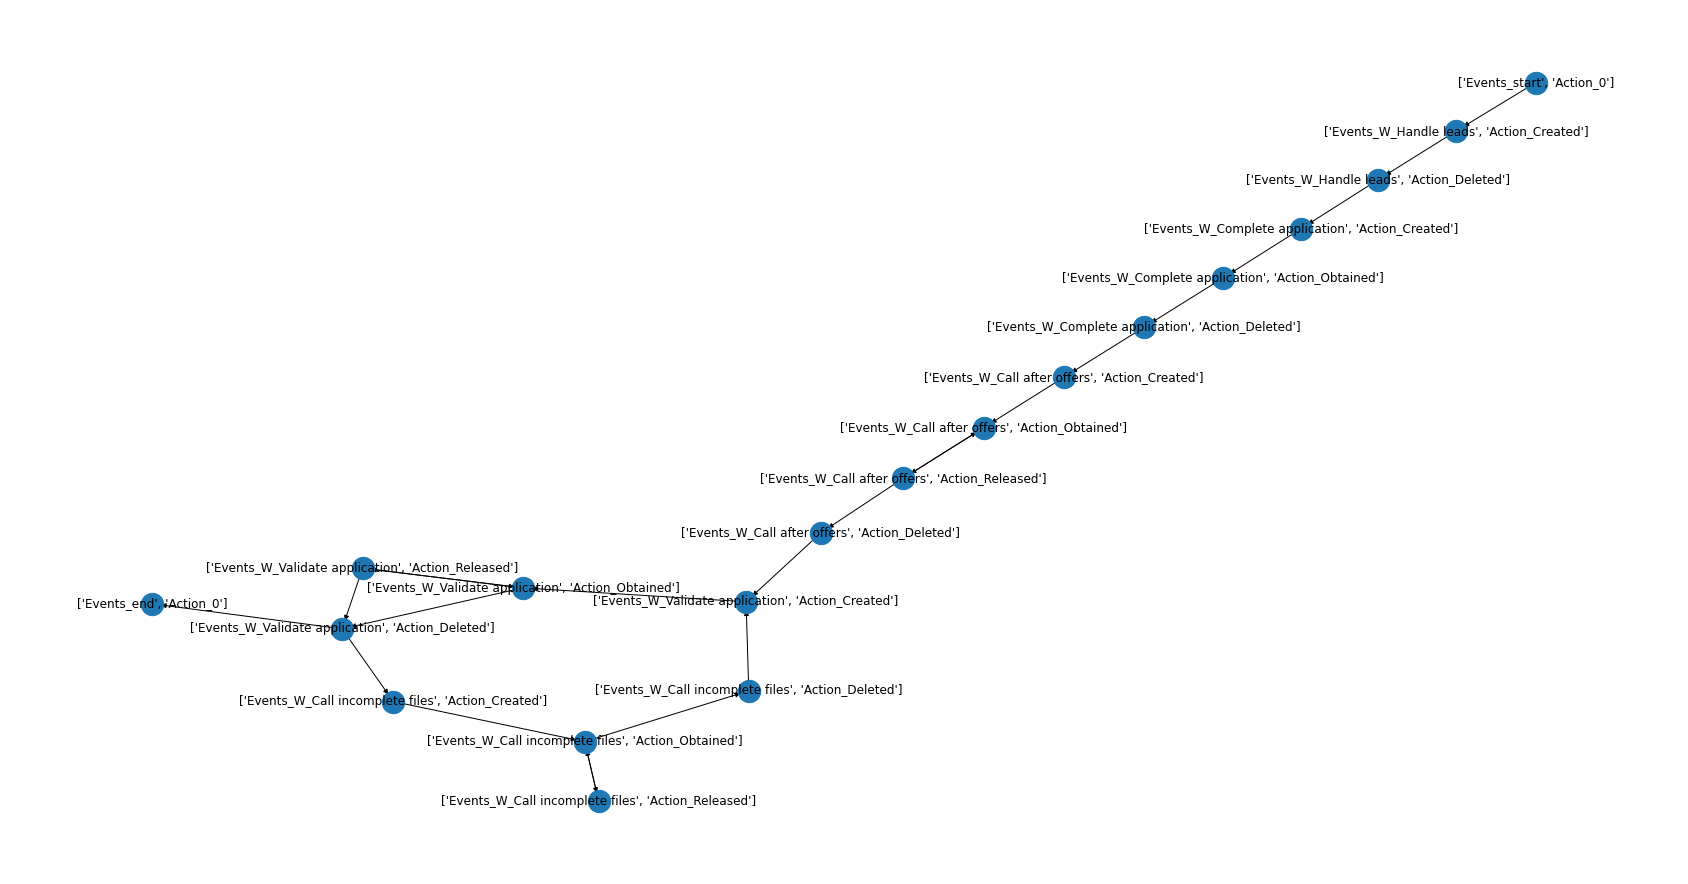

In [ ]:
helper.visualise_dataset(data)

## Analyse des Datensatzes

In [ ]:
df_analyse = loan_application.preprocess_dataset_analysis(df)


In [ ]:
df_analyse.head(30)

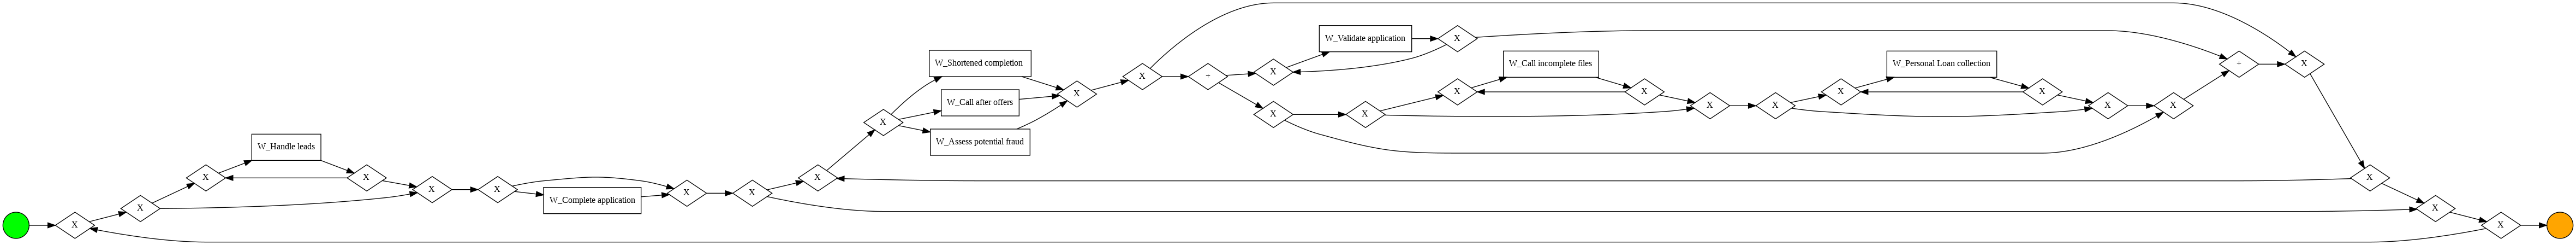

In [ ]:
process_model = pm4py.discover_bpmn_inductive(df_analyse)
pm4py.view_bpmn(process_model)

##DF-Graph

/usr/local/lib/python3.7/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


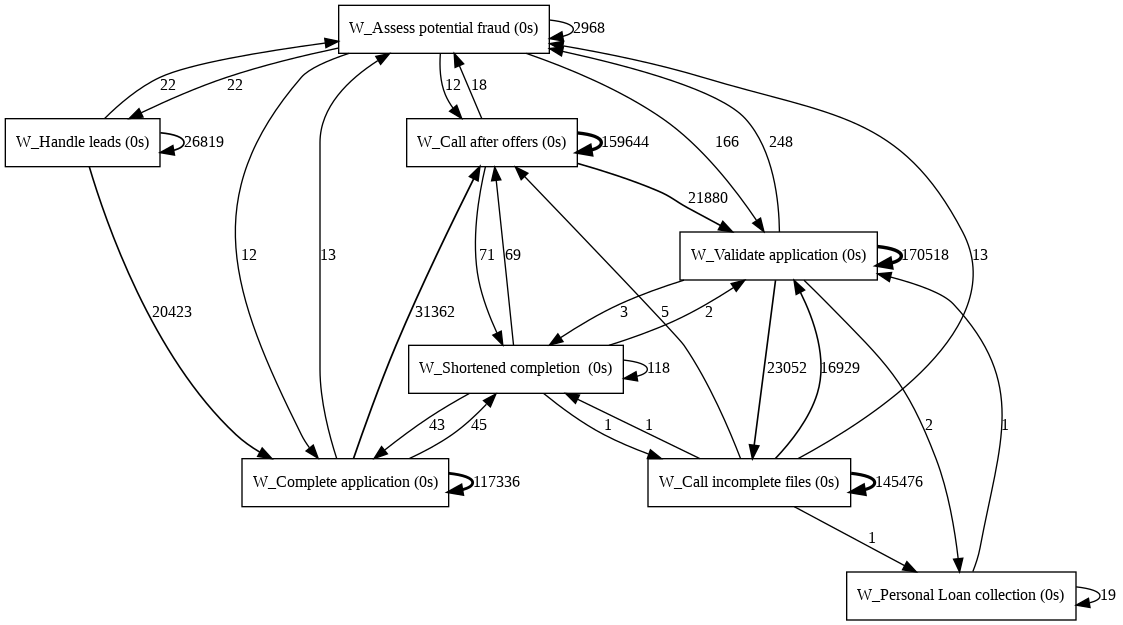

In [ ]:
from pm4py.algo.discovery.dfg import algorithm  as dfg_factory
from pm4py.visualization.dfg import visualizer  as dfg_vis_factory

dfg = dfg_factory.apply(df_analyse)
gviz = dfg_vis_factory.apply(dfg, log=df_analyse)
dfg_vis_factory.view(gviz)

###Label

Labeling ist oben ausgeführt. Hier wurden operationen zum besseren Verständnis der Events, welche zum zuodrdnen der Label verwendet werden, durchgeführt

In [ ]:
df1.rename(columns={"concept:name":"Events", "case:concept:name":"ProcessID", "time:timestamp": "Timestamp", "case:LoanGoal": "LoanGoal" }, inplace=True)

In [ ]:
# Abbruchkriterien
# A Pending: if all documents are received and the assessment is positive, the loan is final and the customer is paid.
# A Denied: if somewhere in the process the loan cannot be offered to the cus tomer, because the application doesn’t fit the acceptance criteria, the application is declined, which results in the status ’denied’. 
# A Cancelled: if the customer never sends in his documents or calls to tell he doesn’t need the loan, the application is cancelled.
process_end = ["A_Pending", "A_Denied", "A_Cancelled"] 

# Check if A_Accepted is in every Group
# g2 = df1.merge(df1.groupby('case:concept:name').apply(lambda x: x['concept:name'].eq("A_Accepted").any()).reset_index(),how='left').rename(columns={0:'Expected_Output'})
# g2["Expected_Output"].value_counts()
# -> A_Accepted not in every Group (not every Row is True)

In [ ]:
g = df2.groupby("ProcessID")

print("Anzahl der Reihen: " + str(df1.size)) # Anzahl an Spalten 22843073
print("Anzahl der Prozesse: " + str(g.ngroups))
print()

Anzahl der Reihen: 22843073
Anzahl der Prozesse: 31509



In [ ]:
# Häufigkeiten der Events
df2.groupby("Events").size()
# Event         Häufigkeit    Label
# A_Pending:    17228         0
# A_Denied:     3753          1
# A_Cancelled:  10431         2

# Alle Groupen ohne die drei Stop events aussortieren
# Prozesse mit diesen Labeln

Events
A_Accepted                     31509
A_Cancelled                    10431
A_Complete                     31362
A_Concept                      31509
A_Create Application           31509
A_Denied                        3753
A_Incomplete                   23055
A_Pending                      17228
A_Submitted                    20423
A_Validating                   38816
O_Accepted                     17228
O_Cancelled                    20898
O_Create Offer                 42995
O_Created                      42995
O_Refused                       4695
O_Returned                     23305
O_Sent (mail and online)       39707
O_Sent (online only)            2026
W_Assess potential fraud        3282
W_Call after offers           191092
W_Call incomplete files       168529
W_Complete application        148900
W_Handle leads                 47264
W_Personal Loan collection        22
W_Shortened completion           238
W_Validate application        209496
dtype: int64

In [ ]:
# Testen ob Stop Events pro Groupe nur einmal vorkommen
# Number of rows in a Group
g3 = df2.groupby(['ProcessID', 'Events']).agg(number_of_rows=('Events', 'count')).reset_index()


In [ ]:
# Analyse der End Events
g4 = g3[g3["Events"] == process_end[0]]
print("Count of Rows with " + process_end[0] + ": " +str(g4["Events"].size)) # 17228
print("Appeareances per Group: ")
print(g4["number_of_rows"].value_counts())
print("--------------------------------------------------------")

g5 = g3[g3["Events"] == process_end[1]]
print("Count of Rows with " + process_end[1] + ": " +str(g5["Events"].size)) # 17228
print("Appeareances per Group: ")
print(g5["number_of_rows"].value_counts())
print("--------------------------------------------------------")

g6 = g3[g3["Events"] == process_end[2]]
print("Count of Rows with " + process_end[2] + ": " +str(g6["Events"].size)) # 17228
print("Appeareances per Group: ")
print(g6["number_of_rows"].value_counts())
print("--------------------------------------------------------")

g7 = g3[(g3["Events"] == process_end[0]) & (g3["Events"] == process_end[1])]
print(f"Overlappings: {process_end[0]} und {process_end[1]}: {g7.size}")
print("--------------------------------------------------------")

g7 = g3[(g3["Events"] == process_end[0]) & (g3["Events"] == process_end[2])]
print(f"Overlappings: {process_end[0]} und {process_end[2]}: {g7.size}")
print("--------------------------------------------------------")

g7 = g3[(g3["Events"] == process_end[1]) & (g3["Events"] == process_end[2])]
print(f"Overlappings: {process_end[1]} und {process_end[2]}: {g7.size}")
print("--------------------------------------------------------")

# In jeder Gruppe soll sich ein End-Word, welches eindeutig definiert, wie der Process zu labeln ist befinden. 
# Gruppen, welche mehrere/ keine End-Wörter enthalten werden aus dem Datensatz entfernt

Count of Rows with A_Pending: 17228
Appeareances per Group: 
1    17228
Name: number_of_rows, dtype: int64
--------------------------------------------------------
Count of Rows with A_Denied: 3752
Appeareances per Group: 
1    3751
2       1
Name: number_of_rows, dtype: int64
--------------------------------------------------------
Count of Rows with A_Cancelled: 10431
Appeareances per Group: 
1    10431
Name: number_of_rows, dtype: int64
--------------------------------------------------------
Overlappings: A_Pending und A_Denied: 0
--------------------------------------------------------
Overlappings: A_Pending und A_Cancelled: 0
--------------------------------------------------------
Overlappings: A_Denied und A_Cancelled: 0
--------------------------------------------------------


In [ ]:
# Löschen der Gruppe mit zwei A_Denied Events
# ProcessID der Gruppe erhalten
a = g3[(g3["number_of_rows"] == 2) & (g3["Events"] == process_end[1])]["ProcessID"].values[0]

# Aus Dataframe löschen
df1 = df1[df1["ProcessID"] != a]
df1["ProcessID"].size

1202184

In [ ]:
# Methode um jeder Gruppe das passende Label zu zuordnen
def add_label(group):  
  if process_end[0] in group.Events.values:
    group["Label"] = 0
    group = group[group.Events != process_end[0]]
    return group
  elif process_end[1] in group.Events.values:
    group["Label"] = 1
    group = group[group.Events != process_end[1]]
    return group
  elif process_end[2] in group.Events.values:
    group["Label"] = 2
    group = group[group.Events != process_end[2]]
    return group

In [ ]:
# create collumn for result of whole Process
df2 = df1.groupby("ProcessID").apply(lambda x: add_label(x))
df2.reset_index(drop = True, inplace = True )
df2.head()

,Action,org:resource,Events,EventOrigin,EventID,lifecycle:transition,Timestamp,LoanGoal,case:ApplicationType,ProcessID,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,Label
0,Created,User_1,A_Create Application,Application,Application_1000086665,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,statechange,User_1,A_Submitted,Application,ApplState_161925113,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,Created,User_1,W_Handle leads,Workflow,Workitem_747707399,schedule,2016-08-03 15:57:21.963000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1030261128,withdraw,2016-08-03 15:58:28.286000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,Created,User_1,W_Complete application,Workflow,Workitem_1127124826,schedule,2016-08-03 15:58:28.293000+00:00,"Other, see explanation",New credit,Application_1000086665,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [ ]:
# Größe der Prozess-Instanzen
df1.groupby(["ProcessID"]).size()


case:concept:name
Application_1000086665     22
Application_1000158214     25
Application_1000311556     18
Application_1000334415     40
Application_1000339879     51
                         ... 
Application_999507989      37
Application_999544538     102
Application_999632431      23
Application_999993467      37
Application_999993812      35
Length: 31509, dtype: int64

In [ ]:
df1, label= loan_application.preprocess_dataset(df1)
df1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Events,ProcessID,Timestamp,LoanGoal
0,4,Application_652823628,2016-01-01 09:51:15.304000+00:00,Existing loan takeover
1,8,Application_652823628,2016-01-01 09:51:15.352000+00:00,Existing loan takeover
2,22,Application_652823628,2016-01-01 09:51:15.774000+00:00,Existing loan takeover
3,22,Application_652823628,2016-01-01 09:52:36.392000+00:00,Existing loan takeover
4,21,Application_652823628,2016-01-01 09:52:36.403000+00:00,Existing loan takeover


In [ ]:
pd_a_test = pd_a.head(200)